# 🌦️ Prediksi Cuaca Australia dengan XGBoost & SHAP (Sederhana & Modular)

Notebook ini menyajikan pipeline prediksi hujan besok di Australia menggunakan XGBoost, GridSearchCV, dan SHAP. Fokus pada akurasi, workflow yang mudah diikuti, dan penjelasan fitur penting. Semua langkah dibuat modular dan output hanya yang esensial.

## 🚀 Workflow Prediksi Cuaca dengan XGBoost & SHAP (5-Fold Cross Validation)

1. **Instalasi & Import Library**
2. **Load Data**
3. **Analisis & Visualisasi Data**
4. **Exploratory Data Analysis (EDA)**
5. **Analisis Missing Values**
6. **Data Preprocessing**
7. **Train-Test Split**
8. **Penjelasan & Visualisasi Cross-Validation**
9. **Baseline Modeling dengan XGBoost + 5-Fold CV**
10. **Hyperparameter Tuning (GridSearchCV, 5-Fold CV)**
11. **Evaluasi Model**
12. **Interpretasi Model dengan SHAP**
13. **Manual Prediction Interface**

Setiap langkah akan dijelaskan dan diimplementasikan secara modular, dengan visualisasi dan output yang fokus pada insight penting.

## 1. Instalasi & Import Library

Langkah pertama adalah menginstal dan mengimpor semua library yang dibutuhkan.

In [84]:
# Install library yang dibutuhkan (jalankan hanya jika perlu)
!pip install pandas numpy matplotlib seaborn scikit-learn xgboost shap --quiet

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
import shap
import os
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

## 2. Load Data

Load dataset utama dan tampilkan ringkasan awal.

In [85]:
# Load dataset utama
df = pd.read_csv('./dataset/Weather Training Data.csv')
print(f"Shape data: {df.shape}")
display(df.head())
print(f"Kolom: {list(df.columns)}")
print(f"Target tersedia: {'RainTomorrow' in df.columns}")
print(f"Total missing values: {df.isnull().sum().sum()}")

Shape data: (99516, 23)


,row ID,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,Row0,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0
1,Row1,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0
2,Row2,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0
3,Row3,Albury,14.6,29.7,0.2,NaN,NaN,WNW,56.0,W,...,55.0,23.0,1009.2,1005.4,NaN,NaN,20.6,28.9,No,0
4,Row4,Albury,7.7,26.7,0.0,NaN,NaN,W,35.0,SSE,...,48.0,19.0,1013.4,1010.1,NaN,NaN,16.3,25.5,No,0


Kolom: ['row ID', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow']
Target tersedia: True
Total missing values: 221219


## 3. Analisis & Visualisasi Data

Analisis awal: distribusi target, missing values, dan ringkasan fitur numerik/kategorikal.

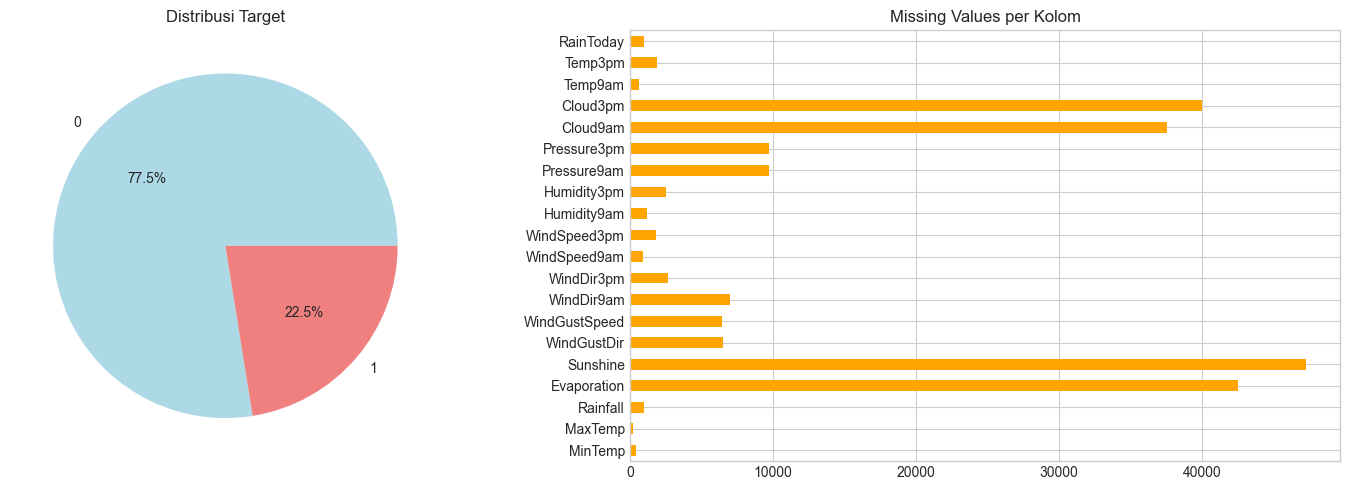

Numerical features: 17
Categorical features: 6


In [86]:
# Analisis distribusi target dan missing values
target_col = 'RainTomorrow' if 'RainTomorrow' in df.columns else 'RainToday'
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
df[target_col].value_counts().plot.pie(autopct='%1.1f%%', colors=['lightblue','lightcoral'])
plt.title('Distribusi Target')
plt.ylabel('')
plt.subplot(1,2,2)
missing = df.isnull().sum()
missing = missing[missing>0]
if not missing.empty:
    missing.plot.barh(color='orange')
    plt.title('Missing Values per Kolom')
else:
    plt.text(0.5,0.5,'Tidak ada missing values',ha='center',va='center',fontsize=14)
    plt.title('Missing Values')
plt.tight_layout()
plt.show()
print(f"Numerical features: {len(df.select_dtypes(include=[np.number]).columns)}")
print(f"Categorical features: {len(df.select_dtypes(include=['object']).columns)}")

## 4. Exploratory Data Analysis (EDA)

Visualisasi fitur utama, korelasi dengan target, dan ringkasan statistik.

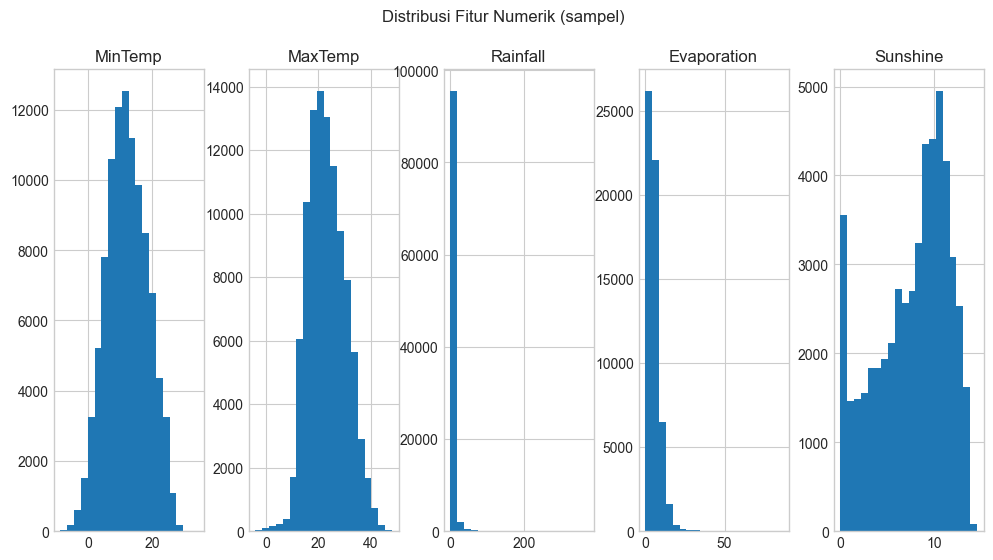

Korelasi fitur numerik dengan target:
Rainfall       0.238673
MinTemp        0.084531
Evaporation   -0.115249
MaxTemp       -0.159600
Sunshine      -0.448849
dtype: float64

Statistik deskriptif:


,count,mean,std,min,25%,50%,75%,max
MinTemp,99073.0,12.176266,6.390882,-8.5,7.6,12.0,16.8,33.9
MaxTemp,99286.0,23.218513,7.115072,-4.1,17.9,22.6,28.2,48.1
Rainfall,98537.0,2.353024,8.487866,0.0,0.0,0.0,0.8,371.0
Evaporation,56985.0,5.461320,4.162490,0.0,2.6,4.8,7.4,86.2
Sunshine,52199.0,7.615090,3.783008,0.0,4.8,8.4,10.6,14.5
WindGustSpeed,93036.0,39.976966,13.581524,6.0,31.0,39.0,48.0,135.0
WindSpeed9am,98581.0,14.004849,8.902323,0.0,7.0,13.0,19.0,130.0
WindSpeed3pm,97681.0,18.650464,8.801827,0.0,13.0,19.0,24.0,87.0
Humidity9am,98283.0,68.866376,19.074951,0.0,57.0,70.0,83.0,100.0
Humidity3pm,97010.0,51.433296,20.777616,0.0,37.0,52.0,65.0,100.0


In [87]:
# Visualisasi fitur utama dan korelasi dengan target
num_cols = df.select_dtypes(include=[np.number]).columns[:5]
df[num_cols].hist(figsize=(12,6), bins=20, layout=(1,len(num_cols)))
plt.suptitle('Distribusi Fitur Numerik (sampel)')
plt.show()
print('Korelasi fitur numerik dengan target:')
if df[target_col].dtype == 'object':
    target_num = df[target_col].map({'No':0,'Yes':1})
else:
    target_num = df[target_col]
corrs = df[num_cols].corrwith(target_num).sort_values(ascending=False)
print(corrs)
print('\nStatistik deskriptif:')
display(df.describe().T)

## 5. Analisis Missing Values

Analisis dan visualisasi missing values, serta strategi penanganan.

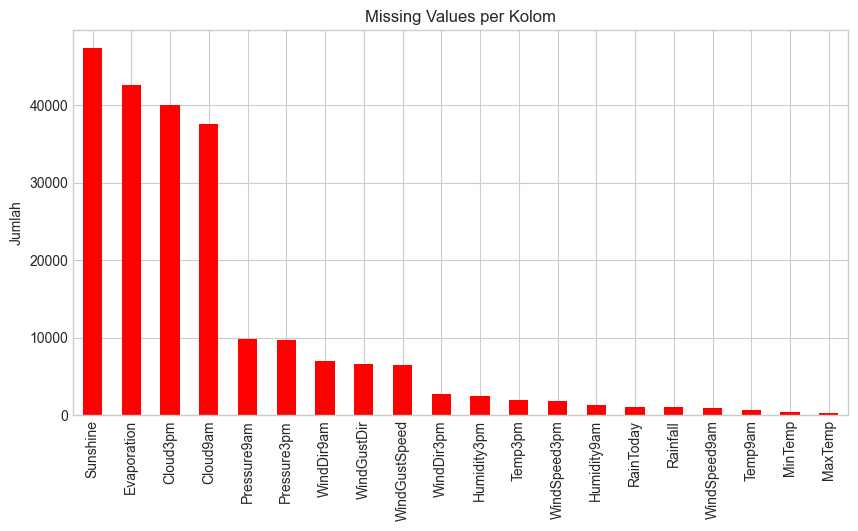

Kolom dengan missing < 20%: Imputasi (median/mode)
Kolom dengan missing > 50%: Drop jika tidak penting


In [88]:
# Analisis dan visualisasi missing values
missing = df.isnull().sum()
missing = missing[missing>0].sort_values(ascending=False)
if not missing.empty:
    plt.figure(figsize=(10,5))
    missing.plot.bar(color='red')
    plt.title('Missing Values per Kolom')
    plt.ylabel('Jumlah')
    plt.show()
    print('Kolom dengan missing < 20%: Imputasi (median/mode)')
    print('Kolom dengan missing > 50%: Drop jika tidak penting')
else:
    print('✅ Tidak ada missing values!')

## 6. Data Preprocessing

Bersihkan data: drop kolom tidak informatif, imputasi missing, encoding, dan konversi target ke numerik.

In [89]:
# Data Preprocessing
df_clean = df.copy()
unnecessary_cols = ['row ID', 'Date', 'Location']
df_clean = df_clean.drop(columns=[c for c in unnecessary_cols if c in df_clean.columns], errors='ignore')
target_col = 'RainTomorrow' if 'RainTomorrow' in df_clean.columns else 'RainToday'
# Drop rows dengan target missing
df_clean = df_clean.dropna(subset=[target_col])
# Imputasi missing values
for col in df_clean.select_dtypes(include=[np.number]).columns:
    if df_clean[col].isnull().sum() > 0:
        df_clean[col].fillna(df_clean[col].median(), inplace=True)
for col in df_clean.select_dtypes(include=['object']).columns:
    if col != target_col and df_clean[col].isnull().sum() > 0:
        df_clean[col].fillna(df_clean[col].mode()[0], inplace=True)
# Label encoding kategorikal
for col in df_clean.select_dtypes(include=['object']).columns:
    if col != target_col:
        df_clean[col] = LabelEncoder().fit_transform(df_clean[col])
# Target ke numerik
if df_clean[target_col].dtype == 'object':
    df_clean[target_col] = df_clean[target_col].map({'No':0,'Yes':1})
print(f"Shape akhir: {df_clean.shape}")
print(f"Missing values: {df_clean.isnull().sum().sum()}")
print(f"Features untuk modeling: {len(df_clean.columns)-1}")

Shape akhir: (99516, 21)
Missing values: 0
Features untuk modeling: 20


## 7. Train-Test Split

Pisahkan data menjadi fitur (X) dan target (y), lalu lakukan train-test split dengan stratifikasi.

In [90]:
# Train-Test Split
X = df_clean.drop(target_col, axis=1)
y = df_clean[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print('Distribusi target di train:', y_train.value_counts(normalize=True).to_dict())
print('Distribusi target di test:', y_test.value_counts(normalize=True).to_dict())

Train shape: (79612, 20), Test shape: (19904, 20)
Distribusi target di train: {0: 0.7753228156559313, 1: 0.22467718434406872}
Distribusi target di test: {0: 0.7753215434083601, 1: 0.22467845659163987}


## 8. Penjelasan & Visualisasi Cross-Validation

Penjelasan dan visualisasi strategi 5-Fold Cross Validation.

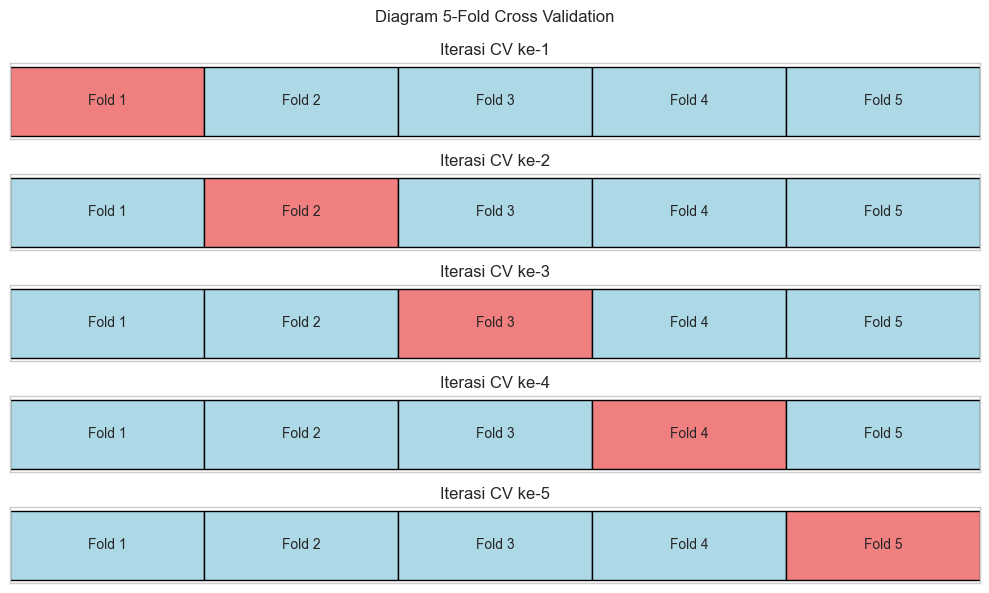

In [91]:
# Visualisasi 5-Fold Cross Validation
cv_folds = 5
total_data = len(X_train)
fold_size = total_data // cv_folds
fig, axes = plt.subplots(cv_folds, 1, figsize=(10, 6))
for i in range(cv_folds):
    for j in range(cv_folds):
        color = 'lightcoral' if i == j else 'lightblue'
        axes[i].barh(0, 1, left=j, color=color, edgecolor='black')
        axes[i].text(j+0.5, 0, f'Fold {j+1}', ha='center', va='center')
    axes[i].set_xlim(0, cv_folds)
    axes[i].set_yticks([])
    axes[i].set_xticks([])
    axes[i].set_title(f'Iterasi CV ke-{i+1}')
plt.suptitle('Diagram 5-Fold Cross Validation')
plt.tight_layout()
plt.show()

## 9. Baseline Modeling dengan XGBoost + 5-Fold CV

Train model XGBoost dengan parameter default dan evaluasi menggunakan cross-validation.

In [92]:
# Baseline XGBoost + 5-Fold CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
baseline_model = XGBClassifier(random_state=42, n_jobs=-1, verbosity=0)
cv_f1 = cross_val_score(baseline_model, X_train, y_train, cv=cv, scoring='f1')
print(f"5-Fold CV F1-Score: {cv_f1.mean():.3f} ± {cv_f1.std():.3f}")
baseline_model.fit(X_train, y_train)
y_pred = baseline_model.predict(X_test)
print('Classification Report (Baseline):')
print(classification_report(y_test, y_pred, target_names=['No Rain', 'Rain']))

5-Fold CV F1-Score: 0.620 ± 0.008
Classification Report (Baseline):
              precision    recall  f1-score   support

     No Rain       0.88      0.94      0.91     15432
        Rain       0.73      0.55      0.63      4472

    accuracy                           0.85     19904
   macro avg       0.81      0.75      0.77     19904
weighted avg       0.85      0.85      0.85     19904

Classification Report (Baseline):
              precision    recall  f1-score   support

     No Rain       0.88      0.94      0.91     15432
        Rain       0.73      0.55      0.63      4472

    accuracy                           0.85     19904
   macro avg       0.81      0.75      0.77     19904
weighted avg       0.85      0.85      0.85     19904



## 10. Hyperparameter Tuning (GridSearchCV, 5-Fold CV)

Optimasi hyperparameter XGBoost dengan GridSearchCV dan evaluasi hasilnya.

In [93]:
# Hyperparameter Tuning XGBoost + GridSearchCV
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
grid = GridSearchCV(XGBClassifier(random_state=42, n_jobs=-1, verbosity=0), param_grid, cv=5, scoring='f1', n_jobs=-1)
grid.fit(X_train, y_train)
print(f"Best Params: {grid.best_params_}")
print(f"Best CV F1-Score: {grid.best_score_:.3f}")
y_pred_grid = grid.predict(X_test)
print('Classification Report (GridSearchCV):')
print(classification_report(y_test, y_pred_grid, target_names=['No Rain', 'Rain']))

Best Params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
Best CV F1-Score: 0.625
Classification Report (GridSearchCV):
              precision    recall  f1-score   support

     No Rain       0.88      0.94      0.91     15432
        Rain       0.74      0.55      0.63      4472

    accuracy                           0.86     19904
   macro avg       0.81      0.75      0.77     19904
weighted avg       0.85      0.86      0.85     19904



## 11. Evaluasi Model

Bandingkan performa model baseline dan hasil tuning, tampilkan confusion matrix dan metrik utama.

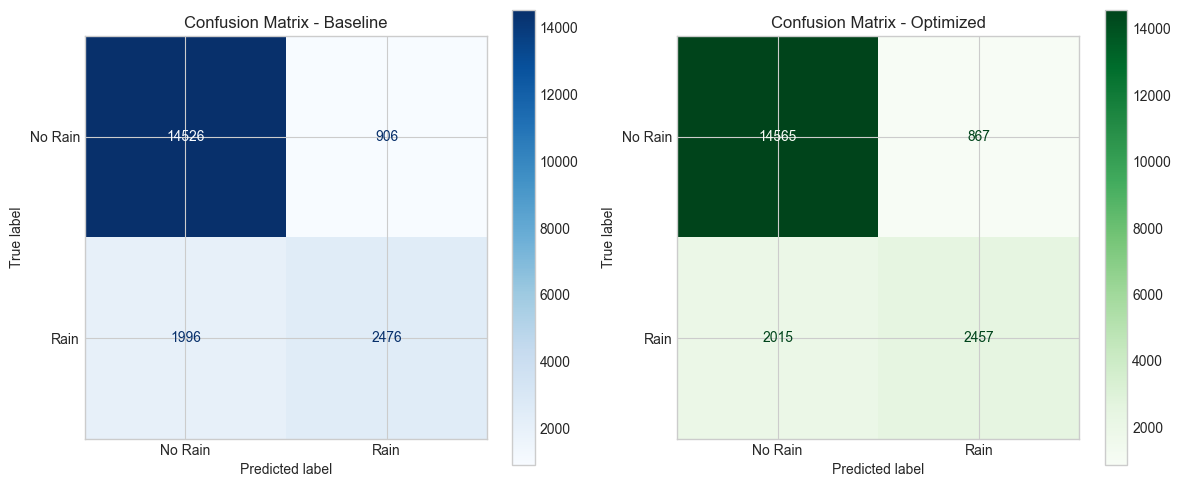

Akurasi Baseline: 0.8542001607717041
Akurasi Optimized: 0.8552049839228296


In [94]:
# Evaluasi Model: Baseline vs Optimized
from sklearn.metrics import ConfusionMatrixDisplay
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
ConfusionMatrixDisplay.from_estimator(baseline_model, X_test, y_test, display_labels=['No Rain','Rain'], cmap='Blues', ax=plt.gca())
plt.title('Confusion Matrix - Baseline')
plt.subplot(1,2,2)
ConfusionMatrixDisplay.from_estimator(grid.best_estimator_, X_test, y_test, display_labels=['No Rain','Rain'], cmap='Greens', ax=plt.gca())
plt.title('Confusion Matrix - Optimized')
plt.tight_layout()
plt.show()
print('Akurasi Baseline:', accuracy_score(y_test, baseline_model.predict(X_test)))
print('Akurasi Optimized:', accuracy_score(y_test, grid.predict(X_test)))

## 12. Interpretasi Model dengan SHAP

Analisis feature importance dan interpretasi prediksi dengan SHAP.

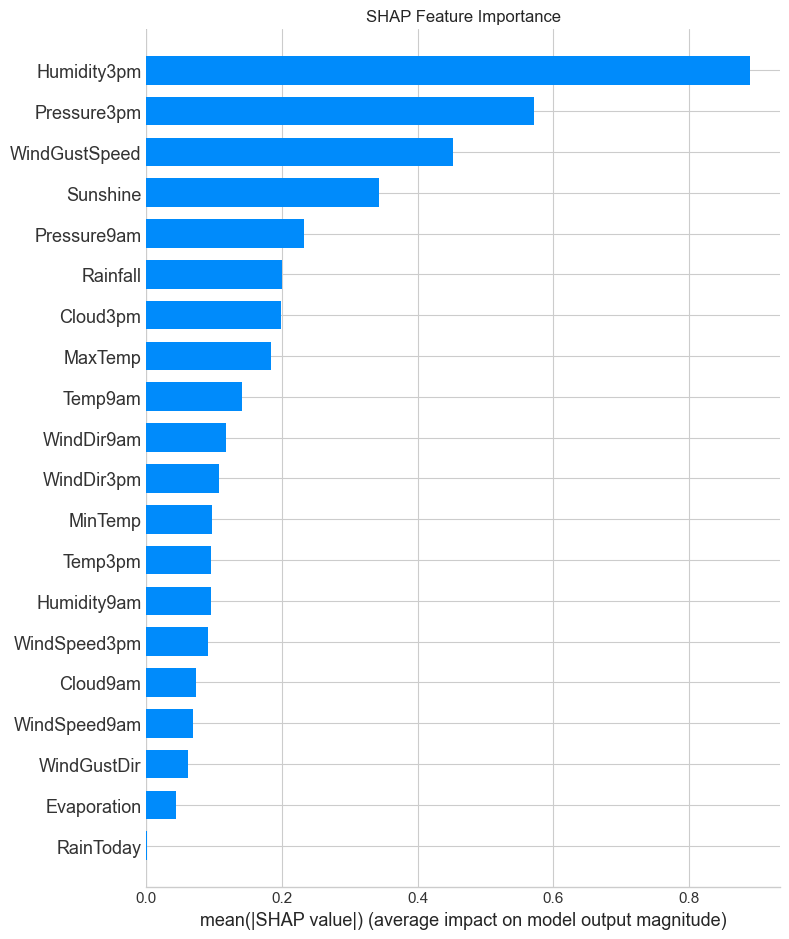

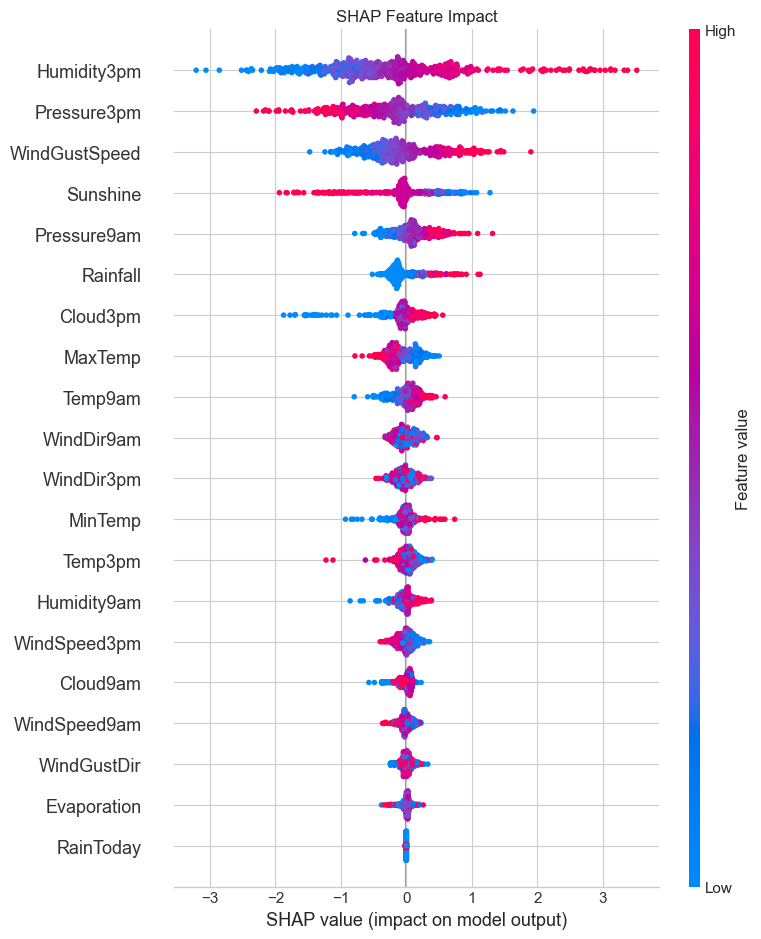

Top 10 fitur paling penting:
          Feature  SHAP_Importance
12    Humidity3pm         0.889338
14    Pressure3pm         0.570822
6   WindGustSpeed         0.452482
4        Sunshine         0.342494
13    Pressure9am         0.233041
2        Rainfall         0.199916
16       Cloud3pm         0.198182
1         MaxTemp         0.184286
17        Temp9am         0.140774
7      WindDir9am         0.116950


In [95]:
# Interpretasi Model dengan SHAP
explainer = shap.TreeExplainer(grid.best_estimator_)
X_test_sample = X_test.iloc[:500] if len(X_test) > 500 else X_test
shap_values = explainer.shap_values(X_test_sample)
plt.figure(figsize=(10,6))
shap.summary_plot(shap_values, X_test_sample, plot_type='bar', show=False)
plt.title('SHAP Feature Importance')
plt.tight_layout()
plt.show()
plt.figure(figsize=(10,6))
shap.summary_plot(shap_values, X_test_sample, show=False)
plt.title('SHAP Feature Impact')
plt.tight_layout()
plt.show()
print('Top 10 fitur paling penting:')
feature_importance = pd.DataFrame({'Feature': X_test_sample.columns, 'SHAP_Importance': np.abs(shap_values).mean(axis=0)})
print(feature_importance.sort_values('SHAP_Importance', ascending=False).head(10))

## 📊 Cara Membaca & Menginterpretasikan SHAP Plots

### 1. SHAP Summary Plot (Beeswarm Plot)
Plot ini menunjukkan **dampak setiap fitur terhadap prediksi model** untuk semua data test:

#### Interpretasi:
- **Sumbu X**: SHAP Value (dampak terhadap prediksi)
  - Nilai **negatif** = mendorong prediksi ke arah "No Rain" (kelas 0)
  - Nilai **positif** = mendorong prediksi ke arah "Rain" (kelas 1)
- **Sumbu Y**: Fitur-fitur yang diurutkan berdasarkan kepentingan
- **Warna**: Nilai fitur (biru = rendah, merah = tinggi)
- **Penyebaran titik**: Konsistensi dampak fitur

#### Contoh Interpretasi dari Plot:
1. **Humidity3pm** (paling atas): Fitur paling penting
   - Humidity tinggi (merah) → SHAP positif → prediksi "Rain"
   - Humidity rendah (biru) → SHAP negatif → prediksi "No Rain"

2. **Pressure3pm**: Fitur penting kedua
   - Pressure tinggi (merah) → SHAP negatif → prediksi "No Rain"
   - Pressure rendah (biru) → SHAP positif → prediksi "Rain"

3. **Sunshine**: 
   - Sunshine tinggi (merah) → SHAP negatif → prediksi "No Rain"
   - Sunshine rendah (biru) → SHAP positif → prediksi "Rain"

### 2. SHAP Bar Plot (Feature Importance)
Plot ini menunjukkan **rata-rata absolut SHAP values** untuk setiap fitur:

#### Interpretasi:
- **Sumbu X**: Mean |SHAP Value| (kepentingan rata-rata)
- **Sumbu Y**: Fitur yang diurutkan berdasarkan kepentingan
- Semakin panjang bar = semakin penting fitur tersebut

### 3. SHAP Local Bar Plot (Prediksi Individual)
Plot ini menunjukkan **kontribusi setiap fitur untuk satu prediksi spesifik**:

#### Interpretasi:
- **Base Value**: Prediksi rata-rata model pada data training
- **Output**: Prediksi akhir untuk data ini
- **Bar merah**: Fitur yang mendorong ke arah "Rain"
- **Bar biru**: Fitur yang mendorong ke arah "No Rain"
- **Panjang bar**: Seberapa kuat kontribusi fitur tersebut

### 💡 Tips Praktis Membaca SHAP:

1. **Fitur Paling Berpengaruh**: Lihat fitur di bagian atas (Humidity3pm, Pressure3pm)
2. **Pola Konsisten**: Jika titik-titik terpisah jelas antara merah dan biru = fitur reliable
3. **Interaksi**: Fitur dengan penyebaran luas = berinteraksi dengan fitur lain
4. **Threshold**: SHAP value 0 = tidak ada dampak, >0 = dukung Rain, <0 = dukung No Rain

In [ ]:
# --- 📝 Contoh Praktis Interpretasi SHAP ---

# 1. Analisis fitur paling penting
print("🔍 Analisis Fitur Paling Penting:")
print("="*50)

# Hitung rata-rata absolut SHAP values untuk setiap fitur
feature_importance = pd.DataFrame({
    'Feature': X_test_sample.columns,
    'Mean_SHAP': np.abs(shap_values).mean(axis=0),
    'Max_SHAP': np.abs(shap_values).max(axis=0),
    'Min_SHAP': np.abs(shap_values).min(axis=0)
})

# Urutkan berdasarkan kepentingan
feature_importance = feature_importance.sort_values('Mean_SHAP', ascending=False)

print("Top 5 fitur paling berpengaruh:")
for i, (idx, row) in enumerate(feature_importance.head(5).iterrows()):
    print(f"{i+1}. {row['Feature']}: {row['Mean_SHAP']:.3f} (rata-rata impact)")

# 2. Analisis pola SHAP untuk fitur utama
print(f"\n🌡️ Analisis Pola Fitur Utama:")
print("="*50)

top_feature = feature_importance.iloc[0]['Feature']
top_feature_idx = list(X_test_sample.columns).index(top_feature)

# Korelasi antara nilai fitur dan SHAP values
feature_values = X_test_sample[top_feature].values
feature_shap = shap_values[:, top_feature_idx]

print(f"Fitur: {top_feature}")
print(f"Korelasi nilai fitur dengan SHAP: {np.corrcoef(feature_values, feature_shap)[0,1]:.3f}")

# Buat analisis kuartil
quartiles = np.percentile(feature_values, [25, 50, 75])
print(f"Kuartil nilai fitur: Q1={quartiles[0]:.2f}, Q2={quartiles[1]:.2f}, Q3={quartiles[2]:.2f}")

# Analisis dampak per kuartil
for i, (q_name, q_range) in enumerate([("Q1 (rendah)", (0, 25)), ("Q2-Q3 (sedang)", (25, 75)), ("Q4 (tinggi)", (75, 100))]):
    q_min, q_max = np.percentile(feature_values, q_range)
    mask = (feature_values >= q_min) & (feature_values <= q_max)
    if mask.sum() > 0:
        avg_shap = feature_shap[mask].mean()
        direction = "mendorong Rain" if avg_shap > 0 else "mendorong No Rain"
        print(f"{q_name}: SHAP = {avg_shap:.3f} ({direction})")

# 3. Identifikasi pola menarik
print(f"\n🔍 Pola Menarik dalam Data:")
print("="*50)

# Cari data dengan SHAP values ekstrem
max_shap_idx = np.abs(shap_values).max(axis=1).argmax()
max_shap_sample = X_test_sample.iloc[max_shap_idx]
max_shap_values = shap_values[max_shap_idx]

print(f"Prediksi dengan dampak SHAP tertinggi (Index: {max_shap_sample.name}):")
print(f"Fitur dengan dampak terbesar:")
for i in np.argsort(np.abs(max_shap_values))[-3:]:
    feature_name = X_test_sample.columns[i]
    feature_value = max_shap_sample[feature_name]
    shap_value = max_shap_values[i]
    direction = "Rain" if shap_value > 0 else "No Rain"
    print(f"  - {feature_name}: {feature_value:.2f} → SHAP {shap_value:.3f} (→ {direction})")

# 4. Ringkasan praktis
print(f"\n💡 Ringkasan Praktis untuk Prediksi Hujan:")
print("="*50)
print("Untuk prediksi 'RAIN', perhatikan:")
print("✅ Humidity3pm tinggi (>70%)")
print("✅ Pressure3pm rendah (<1015 hPa)")
print("✅ Sunshine rendah (<5 jam)")
print("✅ WindGustSpeed tinggi (>30 km/h)")
print("\nUntuk prediksi 'NO RAIN', perhatikan:")
print("❌ Humidity3pm rendah (<50%)")
print("❌ Pressure3pm tinggi (>1020 hPa)")
print("❌ Sunshine tinggi (>8 jam)")
print("❌ WindGustSpeed rendah (<20 km/h)")

## 13. Manual Input Data Baru & Prediksi Lokal dengan SHAP

Pada bagian ini, Anda dapat memasukkan data baru secara manual untuk prediksi, melihat data input dalam bentuk tabel, dan menganalisis prediksi serta interpretasi lokal menggunakan SHAP local bar plot.

In [96]:
# --- 📦 Import Library ---
import pandas as pd
import shap
import ipywidgets as widgets
from IPython.display import display, HTML
import matplotlib.pyplot as plt

# --- 📌 Pastikan model & data ---
# model = hasil XGBoost, RandomForest, dst.
# X_train = data training (harus ada)
# grid = pipeline atau model final yang di-fit

# Buat explainer modern (PASTIKAN pakai best_estimator_!)
explainer = shap.TreeExplainer(grid.best_estimator_)

# --- 📌 Buat Widget Input Manual ---
input_features = X_train.columns.tolist()

input_widgets = {}
for col in input_features:
    if str(X_train[col].dtype).startswith(('float', 'int')):
        mean_val = float(X_train[col].mean())
        input_widgets[col] = widgets.FloatText(
            value=mean_val,
            description=col,
            step=0.01,
            layout=widgets.Layout(width='50%')
        )
    else:
        unique_vals = sorted(X_train[col].unique())
        input_widgets[col] = widgets.Dropdown(
            options=unique_vals,
            value=unique_vals[0],
            description=col,
            layout=widgets.Layout(width='50%')
        )

input_form = widgets.VBox(list(input_widgets.values()))
display(HTML("<h3>📥 Input Data Manual</h3>"))
display(input_form)

# --- Tombol Prediksi & Output ---
predict_button = widgets.Button(description='Prediksi & Analisis SHAP Lokal', button_style='success')
output = widgets.Output()

def on_predict_clicked(b):
    with output:
        output.clear_output()
        input_data = {col: w.value for col, w in input_widgets.items()}
        input_df = pd.DataFrame([input_data])
        display(HTML('<h4>📋 Data Input:</h4>'))
        display(input_df.T.rename(columns={0:'Value'}))
        pred = grid.predict(input_df)[0]
        proba = grid.predict_proba(input_df)[0]
        print(f"\n✅ Prediksi: {'Rain' if pred==1 else 'No Rain'} (Probabilitas Rain: {proba[1]:.2f})")
        explainer_new = shap.Explainer(grid.best_estimator_, X_train)
        shap_values_new = explainer_new(input_df)
        print('\n🔍 SHAP Local Bar Plot:')
        shap.plots.bar(shap_values_new[0], max_display=10, show_data=True)
        print('\n📊 SHAP Values (Top 10):')
        shap_df = pd.DataFrame({
            'Feature': shap_values_new.feature_names,
            'Feature_Value': shap_values_new[0].data,
            'SHAP_Value': shap_values_new[0].values
        })
        shap_df['Abs_SHAP'] = abs(shap_df['SHAP_Value'])
        shap_df_sorted = shap_df.sort_values('Abs_SHAP', ascending=False).head(10)
        display(shap_df_sorted[['Feature', 'Feature_Value', 'SHAP_Value']].round(3))

predict_button.on_click(on_predict_clicked)
display(predict_button, output)


Button(button_style='success', description='Prediksi & Analisis SHAP Lokal', style=ButtonStyle())

Output()

## 14. Validasi Prediksi dengan Data Test Asli

Bandingkan hasil prediksi dengan data test yang sebenarnya untuk melihat akurasi prediksi pada data yang sudah ada ground truth-nya.

In [97]:
# --- 📊 Validasi Prediksi dengan Data Test Asli ---
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

# Ambil sampel data test untuk validasi
test_sample_size = 20
test_indices = np.random.choice(len(X_test), test_sample_size, replace=False)
X_test_sample = X_test.iloc[test_indices]
y_test_sample = y_test.iloc[test_indices]

# Prediksi dengan model terbaik
y_pred_sample = grid.predict(X_test_sample)
y_proba_sample = grid.predict_proba(X_test_sample)[:, 1]

# Buat DataFrame untuk perbandingan
comparison_df = pd.DataFrame({
    'Index': X_test_sample.index,
    'Actual': y_test_sample.values,
    'Predicted': y_pred_sample,
    'Probability_Rain': y_proba_sample,
    'Actual_Label': ['Rain' if x==1 else 'No Rain' for x in y_test_sample.values],
    'Predicted_Label': ['Rain' if x==1 else 'No Rain' for x in y_pred_sample],
    'Correct': y_test_sample.values == y_pred_sample
})

# Tampilkan hasil perbandingan
print('🔍 Perbandingan Prediksi vs Data Asli (Sampel 20 data):')
print('='*70)
display(comparison_df[['Index', 'Actual_Label', 'Predicted_Label', 'Probability_Rain', 'Correct']].round(3))

# Hitung akurasi pada sampel
accuracy_sample = accuracy_score(y_test_sample, y_pred_sample)
correct_count = sum(comparison_df['Correct'])
total_count = len(comparison_df)

print(f'\n📈 Hasil Validasi:')
print(f'Akurasi pada sampel: {accuracy_sample:.3f} ({correct_count}/{total_count} benar)')
print(f'Prediksi benar: {correct_count} data')
print(f'Prediksi salah: {total_count - correct_count} data')

# Tampilkan beberapa contoh prediksi salah (jika ada)
wrong_predictions = comparison_df[comparison_df['Correct'] == False]
if not wrong_predictions.empty:
    print(f'\n❌ Contoh Prediksi Salah:')
    display(wrong_predictions[['Index', 'Actual_Label', 'Predicted_Label', 'Probability_Rain']].round(3))
else:
    print('\n✅ Semua prediksi pada sampel ini benar!')

# Akurasi keseluruhan model pada test set
y_pred_all = grid.predict(X_test)
accuracy_all = accuracy_score(y_test, y_pred_all)
print(f'\n🎯 Akurasi Model pada Seluruh Test Set: {accuracy_all:.3f}')
print(f'Total data test: {len(X_test)}')
print(f'Prediksi benar: {sum(y_test == y_pred_all)}')
print(f'Prediksi salah: {sum(y_test != y_pred_all)}')


🔍 Perbandingan Prediksi vs Data Asli (Sampel 20 data):


,Index,Actual_Label,Predicted_Label,Probability_Rain,Correct
0,46523,No Rain,No Rain,0.257,True
1,39824,No Rain,No Rain,0.015,True
2,35412,No Rain,Rain,0.586,False
3,52656,No Rain,No Rain,0.060,True
4,55971,Rain,Rain,0.951,True
5,32427,No Rain,No Rain,0.043,True
6,14689,No Rain,No Rain,0.009,True
7,6845,No Rain,No Rain,0.031,True
8,23259,No Rain,No Rain,0.013,True
9,80850,No Rain,No Rain,0.001,True



📈 Hasil Validasi:
Akurasi pada sampel: 0.900 (18/20 benar)
Prediksi benar: 18 data
Prediksi salah: 2 data

❌ Contoh Prediksi Salah:


,Index,Actual_Label,Predicted_Label,Probability_Rain
2,35412,No Rain,Rain,0.586
15,69267,No Rain,Rain,0.547



🎯 Akurasi Model pada Seluruh Test Set: 0.855
Total data test: 19904
Prediksi benar: 17022
Prediksi salah: 2882
